# MSML651 Final Project
## Part 2: Prediction using SPARK MLLib
## Julie Lenzer

In this project, I am investigating the classification of poker hands given an ordered list of cards in a draw.

I ran the training data against a number of different classification models and determined that the RandomForest was the best model to use.

In [1]:
import pandas as pd
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

In [2]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Create a File and redirect system output to that file

In [35]:
import sys
    
original_stdout = sys.stdout # Save a reference to the original standard output
outf = open("LenzerOut-RF Prediction.txt", "w")
sys.stdout = outf # Change the standard output to the file we created.
print("MSML651 - Lenzer Final Project\nPrediction using Spark MLlib", "\n\n")

## Initiate Spark Session and use it to load data

Given the size of the test data (1,000,000 records), I will use spark MLLib to make better use of system resources
and multiple processors to train our model, make predictions on the test set and evaluate the outcomes.

In [36]:
# Start Spark session and load both training and test data

spark = SparkSession.builder.appName("MSML651-FinalProj").getOrCreate()

# Load and parse the data file, converting it to a DataFrame.
train_data = spark.read.format("csv").options(header="false", inferSchema="true", sep=",").load("poker-hand-training.data")
test_data = spark.read.format("csv").options(header="false", inferSchema="true", sep=",").load("poker-hand-testing.data")

## Transform the data to be used with Spark MLlib

In order to use the training data with the Spark MLLib random forest, we need to assemble all our categorical data into a single vector to be used in training and prediction.

In [37]:
#Transform the data in the DF to get features into a single vector
#
# Set up list of the categorial columns (which is all of them)
categoricalCols = ['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9']
# Assemble our categorial data into a single vector
assembler = VectorAssembler(inputCols=categoricalCols, outputCol="features")
# Set up a pipeline for all the data prep and transforming features into vectors
#
pipeline = Pipeline(stages = [assembler])
# Transform both the training and test data to assemble and add these feature vectors
train_data = pipeline.fit(train_data).transform(train_data)
test_data = pipeline.fit(test_data).transform(test_data)

## Train the model and run it against the test data

The sequence of tasks include indexing the labels (Y) and the features, running it through the RF model and then converting
the indexes received BACK into label. This is done by evaluating (fit) on the training data and then tranforming the test data

In [38]:
### Train a RandomForest model.
#
# Set up the RF classifier 
rf = RandomForestClassifier(labelCol="_c10", featuresCol="features", featureSubsetStrategy="all", maxDepth=30,maxBins=13,seed=42)

# Chain indexers and forest in a Pipeline followed by the conversion back to the label
pipeline = Pipeline(stages=[rf])

# Train model.  This also runs the indexers.
model = pipeline.fit(train_data)

# Make predictions.
predictions = model.transform(test_data)

## Evaluate outcomes

Look at various measures of our model including accuracy, F1 score, and a mapping of actual to predicted values by class.

In [39]:
evaluator = MulticlassClassificationEvaluator(labelCol="_c10", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g" % accuracy)
evaluator = MulticlassClassificationEvaluator(labelCol="_c10", predictionCol="prediction", metricName="f1")
f1 = evaluator.evaluate(predictions)
print("F1 Score = %g" % f1)

In [40]:
# Create our own mapping of actual class values to predicted
#
pred_val = predictions.select("prediction").toPandas()
actual_val = predictions.select("_c10").toPandas()
pred_pd = pred_val.loc[:,'prediction']
actual_pd = actual_val.loc[:,'_c10']
result = pd.crosstab(actual_pd, pred_pd, rownames=['Actual Result'], colnames=['Predicted Result'])
print(result)
# Close output file and return output to screen
sys.stdout = original_stdout # Reset the standard output to its original value
outf.close() # Close the file

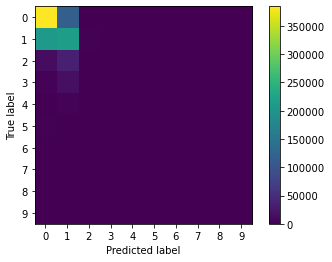

In [41]:
# Develop a graphic version of the Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Pull out true and predicted values
y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("_c10").collect()
# Set up the labels
classLabel = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
# Generate the matrix
cm = confusion_matrix(y_orig, y_pred)
# DIsplay it as a graphic
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classLabel)
disp.plot(include_values= False) 

# Write raw predictions to a file

Write the raw predictions to a csv / text file

In [42]:
#Drop array columns from Spark dataframe in order to write clean data to file
pred_out = predictions.drop('features', 'rawPrediction', 'probability')
pred_out.toPandas().to_csv("LenzerOut - Raw Predictions.csv")

In [43]:
# Stop Spark
spark.stop() # Stop the Spark Session